## **| 분류 연습 문제**
___
출처 : 핸즈온 머신러닝 Ch03 분류 연습문제 1, 2번

In [20]:
# import data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [21]:
X, y = mnist["data"], mnist["target"]

In [22]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### **1. MNIST 데이터셋으로 분류기를 만들어 테스트 세트에서 97% 정확도를 달성해보세요.**
___

1. `KNeghtborsClassifier`를 사용하는 것을 추천합니다.
2. `weights`와 `n_neighbors` 하이퍼 파라미터로 그리드 탐색을 시도하여, 좋은 하이퍼 파라미터 값을 찾아보세요.

In [29]:
# import package
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import numpy as np

In [25]:
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=2, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ....n_neighbors=3, weights=uniform;, score=0.966 total time= 1.1min
[CV 2/2] END ....n_neighbors=3, weights=uniform;, score=0.965 total time=  56.2s
[CV 1/2] END ...n_neighbors=3, weights=distance;, score=0.967 total time=  55.0s
[CV 2/2] END ...n_neighbors=3, weights=distance;, score=0.966 total time=  59.8s
[CV 1/2] END ....n_neighbors=4, weights=uniform;, score=0.962 total time= 1.3min
[CV 2/2] END ....n_neighbors=4, weights=uniform;, score=0.963 total time= 1.1min
[CV 1/2] END ...n_neighbors=4, weights=distance;, score=0.968 total time=  50.5s
[CV 2/2] END ...n_neighbors=4, weights=distance;, score=0.966 total time=  51.2s
[CV 1/2] END ....n_neighbors=5, weights=uniform;, score=0.963 total time=  53.7s
[CV 2/2] END ....n_neighbors=5, weights=uniform;, score=0.964 total time=  52.3s
[CV 1/2] END ...n_neighbors=5, weights=distance;, score=0.965 total time=  51.3s
[CV 2/2] END ...n_neighbors=5, weights=distance;,

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [ ]:
?GridSearchCV

In [26]:
# best hyperparameter
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [27]:
# best score
grid_search.best_score_

0.96685

In [30]:
# model test
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

### **2. 다음 단계를 따라 인위적으로 훈련 세트를 늘리는 데이터 증식 또는 훈련 세트 확장 기법을 연습해봅시다.**
___

#### **STEP 1. MNIST 이미지를 (왼, 오른, 위, 아래) 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수를 만들어 보세요.**

In [31]:
from scipy.ndimage.interpolation import shift

<ipython-input-31-c50379b1544a>:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [32]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

####  **STEP 2. 앞에서 만든 함수를 이용하여, 훈련 세트에 있는 각 이미지에 대해 네 개의 이동된 복사본(방향마다 한 개씩)을 만들어 훈련 세트에 추가하세요**

In [33]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

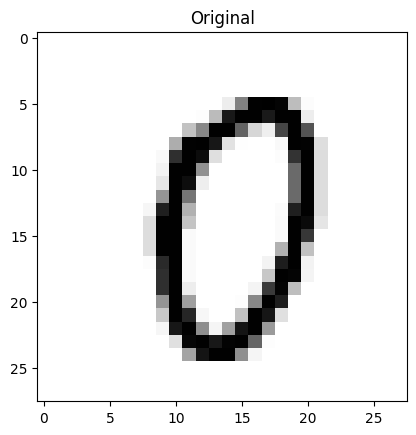

In [34]:
import matplotlib.pyplot as plt
plt.title("Original")
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

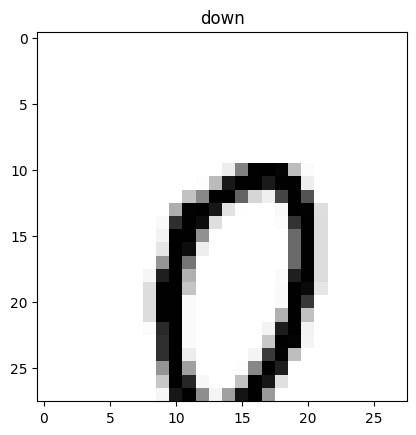

In [35]:
plt.title("down")
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

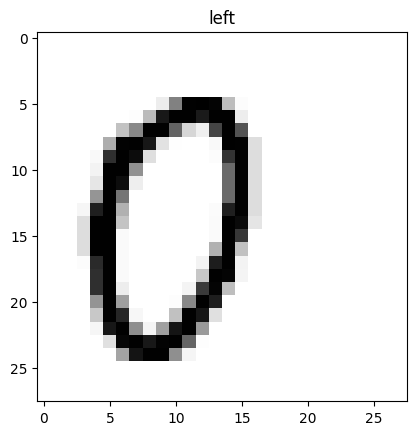

In [36]:
plt.title("left")
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [37]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [38]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

####  **STEP 3. 위에서 확장한 데이터셋을 이용하여, 1번 문제에서 찾은 최적 모델을 훈련시키고, 테스트 세트에서 정확도를 측정해보세요**

In [39]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [40]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [41]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763